In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import pandas as pd
import numpy as np
import math
import random

random_seed = 43
rnd = np.random
rnd.seed(random_seed)

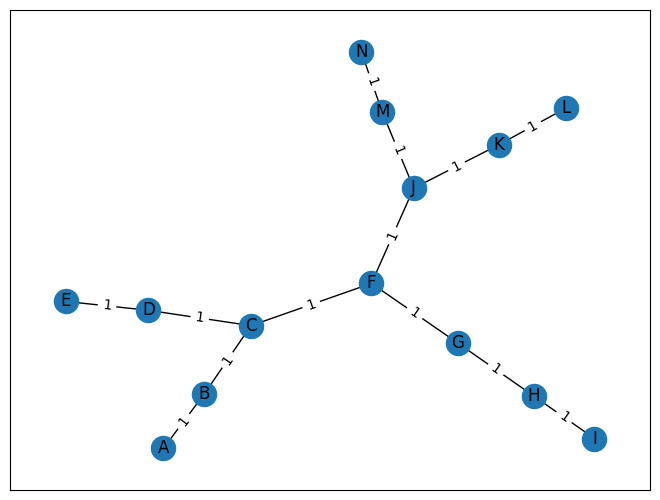

In [2]:
#Configure the nodes and edges
nodes_list = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N']

weights = [('A', 'B', 1), 
         ('B', 'C', 1), 
         ('C', 'D', 1), ('C', 'F', 1) ,
         ('D', 'E', 1),
         ('F', 'G', 1), ('F', 'J', 1) ,
         ('G', 'H', 1), 
         ('H', 'I', 1),
         ('J', 'M', 1), ('J', 'K', 1),
         ('M', 'N', 1),
         ('K', 'L', 1)]

def create_graph_network(nodes_list, weights):
    """
    This function generates and plots a graph object by taking nodes list and edges as input.
    """
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_weighted_edges_from(weights)
    pos=nx.spring_layout(G, seed=random_seed)
    nx.draw(G, pos, with_labels=True)
    edge_weight =(nx.get_edge_attributes(G,'weight'))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)
    plt.axis('on')
    plt.show()
    return G, pos

G, pos = create_graph_network(nodes_list, weights)

In [3]:
def get_coord_of_nodes(pos, nodes_list):
    """
    This function returns a dataframe which contains the x, y 
    co-ordinates of the nodes in the above NetworkX graph object,
    and their corresponding node indices
    """
    xc = []
    yc = []

    for i in pos:
        xc.append(pos[i][0])
        yc.append(pos[i][1])
          
    df = pd.DataFrame()
    df['Node'] = nodes_list
    df['Node_Inbdex'] = [i for i in range(len(nodes_list))]
    df['lats'] = xc
    df['lons'] = yc
    return df

df_nx_coords = get_coord_of_nodes(pos, nodes_list)
df_nx_coords.head(df_nx_coords.shape[0])

,Node,Node_Inbdex,lats,lons
0,A,0,-0.658534,-0.778671
1,B,1,-0.520667,-0.536310
2,C,2,-0.362266,-0.228569
3,D,3,-0.708781,-0.159720
4,E,4,-0.989239,-0.119844
5,F,5,0.045250,-0.038987
6,G,6,0.337840,-0.307105
7,H,7,0.593472,-0.543468
8,I,8,0.799410,-0.734622
9,J,9,0.188335,0.387999


### Distance Matrix Calculation

In [4]:
def get_eq_distance_between_two_nodes(G, i, j):
    """
    Computes the actual path distance between two nodes.
    For example, in the above graph, if we need to compute the 
    distance between node C and G, it will be given by the below formula:
    
    distance(C, G) = eucledian_distance(C,F) + eucledian_distance(F, G)
    
    Note : Since this represents a road network, we will have to consider that
    for the vehicle to reach G from C, it will have to go through F. So 
    the above formulation is the representation of that topic. Think from 
    a perspective of an actual map, where we consider the road distance
    instead of eucledian distance. So we cannot directly consider the eucledian
    distance between C and G.
    
    """
    pos=nx.spring_layout(G, seed=random_seed)
    sp = nx.shortest_path(G, i, j)
    edges_set = [[sp[i], sp[i+1]] for i in range(len(sp)-1)]

    distance_list = []
    for edge in edges_set:
        start_node = edge[0]
        end_node = edge[1]

        x1 = pos[start_node][0]
        y1 = pos[start_node][1]
        x2 = pos[end_node][0]
        y2 = pos[end_node][1]

        distance = math.dist([x1,y1], [x2,y2])
        distance_list.append(distance)

    return (sum(distance_list))

def nodes_connected(G, u, v):
    """
    Check if two nodes share a direct edge connection between them.
    """
    return u in G.neighbors(v)

def create_distance_matrix_eq(G, nodes_list, infinity = False, large = False):
    """
    This function will compute the distance matrix using the 
    above functional logic. It returns a distance matrix df, 
    and a list of list format which is required by Google OR tools.
    If inifity is set to True, it will return a distance matrix, 
    where the distance between two nodes will be set to INF.
    """
    distance_matrix_list = []
    for i in range(len(nodes_list)):
        current_node = nodes_list[i]
        list_of_distance = []
        for j in range(len(nodes_list)):
            target_node = nodes_list[j]            
            if(current_node == target_node):
                actual_distance = 0
            else:
                if(infinity==False and large == False):
                    actual_distance = get_eq_distance_between_two_nodes(G, current_node, target_node)  
                else:
                    check_nodes_connected = nodes_connected(G, current_node, target_node)
                    if(check_nodes_connected):
                        actual_distance = get_eq_distance_between_two_nodes(G, current_node, target_node)
                    else:
                        if(infinity == False and large == True):
                            actual_distance = 999999
                        elif(infinity == True and large == False):
                            actual_distance = float('inf')
                        
            list_of_distance.append(actual_distance)
        distance_matrix_list.append(list_of_distance)
        
    df = pd.DataFrame(distance_matrix_list, columns = nodes_list)
    df.index = nodes_list

    return df, distance_matrix_list

### Actual path distance matrix : Based on the path length between nodes in the NetworkX graph

In [5]:
df_dist_mat_eq, distance_matrix_list_eq = create_distance_matrix_eq(G, nodes_list, infinity = False, large = False)
df_dist_mat_eq.head(df_dist_mat_eq.shape[0])

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
A,0.000000,0.278830,0.624944,0.978233,1.261512,1.074401,1.471259,1.819419,2.100399,1.524723,1.873850,2.154568,1.880207,2.162136
B,0.278830,0.000000,0.346114,0.699403,0.982681,0.795571,1.192428,1.540589,1.821569,1.245893,1.595019,1.875737,1.601377,1.883306
C,0.624944,0.346114,0.000000,0.353289,0.636567,0.449457,0.846314,1.194475,1.475455,0.899779,1.248906,1.529623,1.255263,1.537192
D,0.978233,0.699403,0.353289,0.000000,0.283279,0.802746,1.199603,1.547763,1.828744,1.253067,1.602194,1.882912,1.608552,1.890481
E,1.261512,0.982681,0.636567,0.283279,0.000000,1.086024,1.482882,1.831042,2.112022,1.536346,1.885473,2.166191,1.891830,2.173759
F,1.074401,0.795571,0.449457,0.802746,1.086024,0.000000,0.396858,0.745018,1.025998,0.450322,0.799449,1.080167,0.805806,1.087735
G,1.471259,1.192428,0.846314,1.199603,1.482882,0.396858,0.000000,0.348160,0.629140,0.847180,1.196307,1.477024,1.202664,1.484593
H,1.819419,1.540589,1.194475,1.547763,1.831042,0.745018,0.348160,0.000000,0.280980,1.195340,1.544467,1.825184,1.550824,1.832753
I,2.100399,1.821569,1.475455,1.828744,2.112022,1.025998,0.629140,0.280980,0.000000,1.476320,1.825447,2.106165,1.831805,2.113733
J,1.524723,1.245893,0.899779,1.253067,1.536346,0.450322,0.847180,1.195340,1.476320,0.000000,0.349127,0.629845,0.355484,0.637413


### Very high value for edge pairs with no direct connectivity

In [6]:
df_dist_mat_eq_large, distance_matrix_list_large = create_distance_matrix_eq(G, nodes_list, infinity = False, large = True)
df_dist_mat_eq_large.head(df_dist_mat_eq_large.shape[0])

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
A,0.00000,0.278830,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
B,0.27883,0.000000,0.346114,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
C,999999.00000,0.346114,0.000000,0.353289,999999.000000,0.449457,999999.000000,999999.00000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
D,999999.00000,999999.000000,0.353289,0.000000,0.283279,999999.000000,999999.000000,999999.00000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
E,999999.00000,999999.000000,999999.000000,0.283279,0.000000,999999.000000,999999.000000,999999.00000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
F,999999.00000,999999.000000,0.449457,999999.000000,999999.000000,0.000000,0.396858,999999.00000,999999.00000,0.450322,999999.000000,999999.000000,999999.000000,999999.000000
G,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,0.396858,0.000000,0.34816,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
H,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,0.348160,0.00000,0.28098,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
I,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,0.28098,0.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
J,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,0.450322,999999.000000,999999.00000,999999.00000,0.000000,0.349127,999999.000000,0.355484,999999.000000


### Infinite value for edge pairs with no direct connectivity

In [7]:
df_dist_mat_eq_inf, distance_matrix_list_inf = create_distance_matrix_eq(G, nodes_list, infinity = True, large = False)
df_dist_mat_eq_inf.head(df_dist_mat_eq_inf.shape[0])

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
A,0.00000,0.278830,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
B,0.27883,0.000000,0.346114,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
C,inf,0.346114,0.000000,0.353289,inf,0.449457,inf,inf,inf,inf,inf,inf,inf,inf
D,inf,inf,0.353289,0.000000,0.283279,inf,inf,inf,inf,inf,inf,inf,inf,inf
E,inf,inf,inf,0.283279,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,inf
F,inf,inf,0.449457,inf,inf,0.000000,0.396858,inf,inf,0.450322,inf,inf,inf,inf
G,inf,inf,inf,inf,inf,0.396858,0.000000,0.34816,inf,inf,inf,inf,inf,inf
H,inf,inf,inf,inf,inf,inf,0.348160,0.00000,0.28098,inf,inf,inf,inf,inf
I,inf,inf,inf,inf,inf,inf,inf,0.28098,0.00000,inf,inf,inf,inf,inf
J,inf,inf,inf,inf,inf,0.450322,inf,inf,inf,0.000000,0.349127,inf,0.355484,inf


### Solution using actual path distance Matrix

In [8]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_list_eq
    data['demands'] = [random.randint(1,5) for i in range(len(distance_matrix_list_eq))]
    data['num_vehicles'] = 4
    data['vehicle_capacities'] = [20 for i in range(data['num_vehicles'])] # Each vehicle capacity is 15 units
    data['depot'] = 'A' #Consider A to be the starting node index
    return data


def print_solution(data, manager, routing, solution, nodes_list):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        route_path = []
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(nodes_list[node_index], route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            route_path.append(nodes_list[node_index])
        plan_output += ' {0} Load({1})\n'.format(nodes_list[manager.IndexToNode(index)],route_load)
        route_path.append(nodes_list[manager.IndexToNode(index)])
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
        print("Vehicle Route for vehicle {}: ".format(vehicle_id), route_path)
        print()
        
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], nodes_list.index(data['depot']))

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution, nodes_list)
    else:
        print("No Solution")


if __name__ == '__main__':
    main()

Objective: 4
Route for vehicle 0:
 A Load(5) ->  A Load(5)
Distance of the route: 0m
Load of the route: 5
Vehicle Route for vehicle 0:  ['A', 'A']

Route for vehicle 1:
 A Load(5) ->  B Load(9) ->  E Load(10) ->  H Load(14) ->  I Load(15) ->  G Load(20) ->  A Load(20)
Distance of the route: 2m
Load of the route: 20
Vehicle Route for vehicle 1:  ['A', 'B', 'E', 'H', 'I', 'G', 'A']

Route for vehicle 2:
 A Load(5) ->  M Load(8) ->  N Load(13) ->  J Load(18) ->  L Load(19) ->  K Load(20) ->  A Load(20)
Distance of the route: 2m
Load of the route: 20
Vehicle Route for vehicle 2:  ['A', 'M', 'N', 'J', 'L', 'K', 'A']

Route for vehicle 3:
 A Load(5) ->  C Load(9) ->  F Load(13) ->  D Load(16) ->  A Load(16)
Distance of the route: 0m
Load of the route: 16
Vehicle Route for vehicle 3:  ['A', 'C', 'F', 'D', 'A']

Total distance of all routes: 4m
Total load of all routes: 61


### Solution using high value number distance Matrix


In [9]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_list_large
    data['demands'] = [random.randint(1,5) for i in range(len(distance_matrix_list_large))]
    data['num_vehicles'] = 4
    data['vehicle_capacities'] = [20 for i in range(data['num_vehicles'])] # Each vehicle capacity is 15 units
    data['depot'] = 'A' #Consider A to be the starting node index
    return data

In [10]:
if __name__ == '__main__':
    main()

Objective: 5999994
Route for vehicle 0:
 A Load(5) ->  A Load(5)
Distance of the route: 0m
Load of the route: 5
Vehicle Route for vehicle 0:  ['A', 'A']

Route for vehicle 1:
 A Load(5) ->  I Load(10) ->  H Load(14) ->  D Load(16) ->  E Load(20) ->  A Load(20)
Distance of the route: 2999997m
Load of the route: 20
Vehicle Route for vehicle 1:  ['A', 'I', 'H', 'D', 'E', 'A']

Route for vehicle 2:
 A Load(5) ->  N Load(8) ->  M Load(10) ->  J Load(14) ->  K Load(18) ->  L Load(19) ->  A Load(19)
Distance of the route: 1999998m
Load of the route: 19
Vehicle Route for vehicle 2:  ['A', 'N', 'M', 'J', 'K', 'L', 'A']

Route for vehicle 3:
 A Load(5) ->  B Load(10) ->  C Load(12) ->  F Load(17) ->  G Load(19) ->  A Load(19)
Distance of the route: 999999m
Load of the route: 19
Vehicle Route for vehicle 3:  ['A', 'B', 'C', 'F', 'G', 'A']

Total distance of all routes: 5999994m
Total load of all routes: 63


### Solution using Infinity number distance Matrix


In [11]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_list_inf
    data['demands'] = [random.randint(1,5) for i in range(len(distance_matrix_list_inf))]
    data['num_vehicles'] = 4
    data['vehicle_capacities'] = [20 for i in range(data['num_vehicles'])] # Each vehicle capacity is 15 units
    data['depot'] = 'A' #Consider A to be the starting node index
    return data

In [12]:
if __name__ == '__main__':
    main()

Objective: 0
Route for vehicle 0:
 A Load(3) ->  A Load(3)
Distance of the route: 0m
Load of the route: 3
Vehicle Route for vehicle 0:  ['A', 'A']

Route for vehicle 1:
 A Load(3) ->  F Load(8) ->  E Load(12) ->  D Load(17) ->  C Load(20) ->  A Load(20)
Distance of the route: 0m
Load of the route: 20
Vehicle Route for vehicle 1:  ['A', 'F', 'E', 'D', 'C', 'A']

Route for vehicle 2:
 A Load(3) ->  J Load(8) ->  I Load(13) ->  H Load(18) ->  B Load(20) ->  A Load(20)
Distance of the route: 0m
Load of the route: 20
Vehicle Route for vehicle 2:  ['A', 'J', 'I', 'H', 'B', 'A']

Route for vehicle 3:
 A Load(3) ->  N Load(6) ->  M Load(10) ->  L Load(13) ->  K Load(17) ->  G Load(19) ->  A Load(19)
Distance of the route: 0m
Load of the route: 19
Vehicle Route for vehicle 3:  ['A', 'N', 'M', 'L', 'K', 'G', 'A']

Total distance of all routes: 0m
Total load of all routes: 62


### Adding code to specify which nodes are connected to which

    #Calculate the edges list
    edges = list(G.edges())
    edges_indexes = [(nodes_list.index(i[0]), nodes_list.index(i[1])) for i in edges]
    
    #Setting constraint to specify that the vehicle can only travel from A to B, B to C, I to J, etc, and vice-versa.
    for edge in edges_indexes:
        routing.NextVar(edge[0]).SetValues([edge[0], edge[1]])

    for edge in edges_indexes:
        routing.NextVar(edge[1]).SetValues([edge[1], edge[0]])

In [101]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_list_eq
    data['demands'] = [random.randint(1,5) for i in range(len(distance_matrix_list_eq))]
    data['num_vehicles'] = 4
    data['vehicle_capacities'] = [20 for i in range(data['num_vehicles'])] # Each vehicle capacity is 15 units
    data['depot'] = 'A' #Consider A to be the starting node index
    return data


def print_solution(data, manager, routing, solution, nodes_list):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        route_path = []
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(nodes_list[node_index], route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            route_path.append(nodes_list[node_index])
        plan_output += ' {0} Load({1})\n'.format(nodes_list[manager.IndexToNode(index)],route_load)
        route_path.append(nodes_list[manager.IndexToNode(index)])
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
        print("Vehicle Route for vehicle {}: ".format(vehicle_id), route_path)
        print()
        
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], nodes_list.index(data['depot']))

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    #Calculate the edges list
    edges = list(G.edges())
    edges_indexes = [(nodes_list.index(i[0]), nodes_list.index(i[1])) for i in edges]
    
    #Setting constraint to specify that the vehicle can only travel from A to B, B to C, C to D...I to J, etc, and vice-versa.
    for edge in edges_indexes:
        routing.NextVar(edge[0]).SetValues([edge[0], edge[1]])

    for edge in edges_indexes:
        routing.NextVar(edge[1]).SetValues([edge[1], edge[0]])

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution, nodes_list)
    else:
        print("No Solution")


if __name__ == '__main__':
    main()

No Solution
